In [26]:
import os
import sys
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import random

import gym
import torch
import torch.nn as nn
import torch.optim as optim

# configure module & syspath
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.agent import Policy
from src.agent.replay_memory import ReplayMemory, Transition

In [27]:
max_episodes = 10_000
max_trajectory_length = 100
gamma = 0.99

epsilon = 1.
epsilon_annealing = 0.9 / 1_000_000

batch_size = 128
target_update_frequency = 25

In [28]:
env = gym.make('CartPole-v1')
observation_space = env.observation_space
action_space = env.action_space

In [29]:
# initialize policy network
policy_net = Policy(observation_space.shape[0], action_space.n)

# initialize the target network since DQN learns off-policy
target_net = Policy(observation_space.shape[0], action_space.n)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# optimizer for the policy network
optimizer = optim.RMSprop(policy_net.parameters(), lr=0.01)

# replay memory to keep track of past states & actions.
replay_memory = ReplayMemory(capacity=1_000)
episode_durations = list()

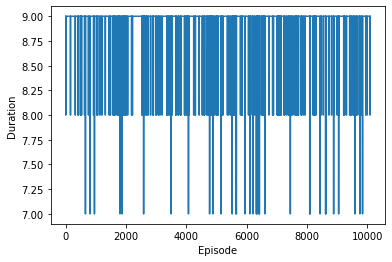

In [33]:
for i_episode in range(1, max_episodes):
    obs, _ = env.reset()
    state = torch.from_numpy(obs).unsqueeze(0)

    is_done = False
    trajectory_length = 0

    for t in range(max_trajectory_length):
        if is_done:
            break

        if np.random.random() < epsilon:
            action = torch.tensor([[random.randrange(env.action_space.n)]], device='cpu', dtype=torch.long)
        else:
            with torch.no_grad():
                action = policy_net(state).argmax().view(1, 1)

        # take an action in the environment.
        new_obs, reward, is_done, _, _ = env.step(action.item())
        next_state = torch.from_numpy(new_obs).unsqueeze(0)
        reward = torch.tensor([reward], device='cpu')

        # add the current transition to the replay memory.
        transition = Transition(state, action, reward, next_state)
        replay_memory.add_step(transition)
        state = next_state
        pass

        # anneal the value of epsilon as we iterate through episodes.
        if epsilon > 0.1:
            epsilon -= epsilon_annealing

        trajectory_length = t
        pass
    # end of for loop

    # optimize the model if we have enough samples in memory
    if replay_memory.is_full:
        sampled_transitions = replay_memory.sample(batch_size)
        batch = Transition(*zip(*sampled_transitions))

        # train the neural net
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(batch_size)
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * gamma) + reward_batch

        # compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # run the optimizer
        optimizer.zero_grad()
        loss.backward()

        for param in policy_net.parameters():
            param.grad.data.clamp_(-1, 1)

        optimizer.step()
        pass

    if i_episode % target_update_frequency == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # plot the current trajectories
    episode_durations.append(trajectory_length)
    pass

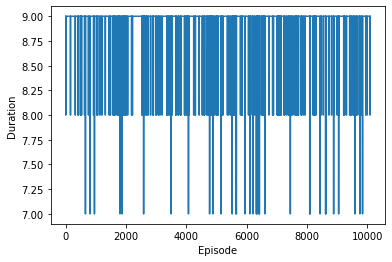

In [34]:
# end of training, plot the episode durations after training is done.
plt.figure(2)
plt.clf()
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(episode_durations)